In [1]:
import pandas as pd
from sklearn.metrics import DistanceMetric
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from sklearn.manifold import MDS
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from sklearn.preprocessing import StandardScaler
from skbio.stats.composition import clr
import re
import os
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv("gbs_cohort_taxonomy_raw_counts_2024-06-20.txt", sep="\t")
smoothed = df + 1
relative_abundances = smoothed.div(smoothed.sum(axis=1), axis=0)
relative_abundances

,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus_faecalis,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella_pneumoniae,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli_C,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli_D,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_flexneri,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Leclercia;s__Leclercia_sp002902985,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_sp005843885,k__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus_epidermidis,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus_pseudopneumoniae_O,...,k__Bacteria;p__Firmicutes;c__Bacilli;o__Brevibacillales;f__Brevibacillaceae;g__Brevibacillus;s__Brevibacillus_thermoruber,k__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfosarcinaceae;g__Desulfatitalea;s__Desulfatitalea_tepidiphila,k__Bacteria;p__Patescibacteria;c__CPR2;o__CG2-30-33-46;f__CG2-30-33-46;g__CG2-30-33-46;s__CG2-30-33-46_sp002792735,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Gallionellaceae;g__Nitrotoga;s__Nitrotoga_sp002470125,k__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__UBA935;s__UBA935_sp002293525,k__Bacteria;p__Firmicutes;c__Bacilli;o__RFN20;f__CAG-288;g__UBA7642;s__UBA7642_sp900313465,k__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium_aquidurense_B,k__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__UBA9464;g__SXXZ01;s__SXXZ01_sp005789375,k__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Mycobacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium_saopaulense,k__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__UBA1066;s__UBA1066_sp900319795
magic.0022,0.000148,0.000882,0.252547,0.021199,0.187892,0.282596,3.751112e-07,0.007466,0.000051,0.000001,...,3.751112e-07,3.751112e-07,3.751112e-07,3.751112e-07,3.751112e-07,3.751112e-07,3.751112e-07,3.751112e-07,3.751112e-07,3.751112e-07
magic.1142,0.000109,0.000155,0.002811,0.000213,0.001686,0.000302,6.658284e-06,0.000052,0.000006,0.000005,...,9.511834e-07,9.511834e-07,9.511834e-07,9.511834e-07,9.511834e-07,9.511834e-07,9.511834e-07,9.511834e-07,9.511834e-07,9.511834e-07
magic.0519,0.000283,0.000140,0.040913,0.002505,0.022318,0.030635,4.116467e-05,0.000931,0.000071,0.000010,...,8.948842e-07,8.948842e-07,8.948842e-07,8.948842e-07,8.948842e-07,8.948842e-07,8.948842e-07,8.948842e-07,8.948842e-07,8.948842e-07
magic.0051,0.000355,0.000168,0.000618,0.000040,0.000516,0.000017,4.411049e-04,0.000006,0.002021,0.000042,...,1.011709e-06,1.011709e-06,1.011709e-06,1.011709e-06,1.011709e-06,1.011709e-06,1.011709e-06,1.011709e-06,1.011709e-06,1.011709e-06
magic.1120,0.000002,0.000060,0.003740,0.000015,0.000182,0.000034,1.082034e-06,0.000003,0.000001,0.000005,...,1.082034e-06,1.082034e-06,1.082034e-06,1.082034e-06,1.082034e-06,1.082034e-06,1.082034e-06,1.082034e-06,1.082034e-06,1.082034e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
magic.5263,0.003063,0.000018,0.000096,0.000011,0.000039,0.000048,2.294052e-06,0.000002,0.009956,0.000608,...,2.294052e-06,2.294052e-06,2.294052e-06,2.294052e-06,2.294052e-06,2.294052e-06,2.294052e-06,2.29

In [3]:
relative_abundances.sum(axis=1)

magic.0022    1.0
magic.1142    1.0
magic.0519    1.0
magic.0051    1.0
magic.1120    1.0
             ... 
magic.5263    1.0
magic.5187    1.0
magic.5176    1.0
magic.5175    1.0
magic.5088    1.0
Length: 1381, dtype: float64

In [4]:
metadata = pd.read_csv("gbs_cohort_metadata_2024-06-20.txt", sep="\t", index_col=1)
metadata

,magic_id,time_cat,del_method,matabx_expo_cat,dist_tp,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_timeline.prior..during..after.,...,parity_n,laboronset_type,multip_yn,rom_hr,sepsisrisk,gbs_result,motherrace,motherethnicity,maternalheight,weight_prepregnancy_2
sample_id,,,,,,,,,,,,,,,,,,,,,
magic.0022,101,1,Vaginal,No antibiotics,NaN,NaN,NaN,3,regular,NaN,...,2,Induced,No,4.10,0.10,Negative,White,Non-Hispanic,167.6,125.0
magic.1142,101,12,Vaginal,No antibiotics,0.11,2017-12-11,1330,48,regular,NaN,...,2,Induced,No,4.10,0.10,Negative,White,Non-Hispanic,167.6,125.0
magic.0519,101,6,Vaginal,No antibiotics,0.09,2017-06-11,NaN,24,regular,NaN,...,2,Induced,No,4.10,0.10,Negative,White,Non-Hispanic,167.6,125.0
magic.0051,102,1,Vaginal,No antibiotics,0.01,2017-01-11,2130,4,regular,NaN,...,1,Spontaneous,No,3.95,0.14,Negative,White,Non-Hispanic,177.8,165.0
magic.1120,102,12,Vaginal,No antibiotics,0.01,2017-12-12,NaN,48,regular,NaN,...,1,Spontaneous,No,3.95,0.14,Negative,White,Non-Hispanic,177.8,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
magic.5263,599,0,Vaginal,No antibiotics,0.26,2019-09-18,2000,1,regular,NaN,...,1,Induced,No,28.17,0.28,Negative,Asian,Unknown / Not Reported,161.3,125.0
magic.5187,601,0,C-section,Other antibiotics,0.23,2019-09-20,2210,1,regular,NaN,...,1,NaN,No,0.00,0.03,Negative,White,Non-Hispanic,162.6,145.0
magic.5176,603,0,Vaginal,No antibiotics,0.26,2019-09-25,1025,1,regular,NaN,...,2,Spontaneous,No,4.72,0.14,Negative,White,Non-Hispanic,162.6,135.0


In [5]:
transformed = pd.DataFrame(clr(relative_abundances), index=relative_abundances.index, columns=relative_abundances.columns)
transformed

,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus_faecalis,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella_pneumoniae,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli_C,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli_D,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_flexneri,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Leclercia;s__Leclercia_sp002902985,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_sp005843885,k__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus_epidermidis,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus_pseudopneumoniae_O,...,k__Bacteria;p__Firmicutes;c__Bacilli;o__Brevibacillales;f__Brevibacillaceae;g__Brevibacillus;s__Brevibacillus_thermoruber,k__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfosarcinaceae;g__Desulfatitalea;s__Desulfatitalea_tepidiphila,k__Bacteria;p__Patescibacteria;c__CPR2;o__CG2-30-33-46;f__CG2-30-33-46;g__CG2-30-33-46;s__CG2-30-33-46_sp002792735,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Gallionellaceae;g__Nitrotoga;s__Nitrotoga_sp002470125,k__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__UBA935;s__UBA935_sp002293525,k__Bacteria;p__Firmicutes;c__Bacilli;o__RFN20;f__CAG-288;g__UBA7642;s__UBA7642_sp900313465,k__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium_aquidurense_B,k__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__UBA9464;g__SXXZ01;s__SXXZ01_sp005789375,k__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Mycobacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium_saopaulense,k__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__UBA1066;s__UBA1066_sp900319795
magic.0022,5.765606,7.548891,13.206606,10.728946,12.910874,13.319028,-0.213280,9.685396,4.691995,0.885333,...,-0.213280,-0.213280,-0.213280,-0.213280,-0.213280,-0.213280,-0.213280,-0.213280,-0.213280,-0.213280
magic.1142,4.392646,4.741464,7.638968,5.059360,7.128142,5.409765,1.593624,3.655047,1.439473,1.257152,...,-0.352286,-0.352286,-0.352286,-0.352286,-0.352286,-0.352286,-0.352286,-0.352286,-0.352286,-0.352286
magic.0519,5.541968,4.842472,10.516495,7.723243,9.910454,10.227201,3.614867,6.733202,4.155674,2.184121,...,-0.213774,-0.213774,-0.213774,-0.213774,-0.213774,-0.213774,-0.213774,-0.213774,-0.213774,-0.213774
magic.0051,5.660642,4.911843,6.214952,3.488735,6.034266,2.633069,5.877498,1.591615,7.399757,3.537525,...,-0.200145,-0.200145,-0.200145,-0.200145,-0.200145,-0.200145,-0.200145,-0.200145,-0.200145,-0.200145
magic.1120,0.318374,3.632560,7.773094,2.264284,4.749191,3.059214,-0.374773,0.723839,-0.374773,1.234665,...,-0.374773,-0.374773,-0.374773,-0.374773,-0.374773,-0.374773,-0.374773,-0.374773,-0.374773,-0.374773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
magic.5263,7.036354,1.919109,3.577337,1.449106,2.672881,2.884190,-0.160332,-0.160332,8.215297,5.419398,...,-0.160332,-0.160332,-0.160332,-0.160332,-0.160332,-0.160332,-0.160332,-0.160332,-0.160332,-0.160332
magic.5187,9.872748,13.155048,7.671913,1.810720,6.801153,3.890162,5.122306,0.557957,10.131516,5.148014,...,-0.135190,-0.135190,-0.135190,-0.135190,-0.135190,-

In [6]:
metadata = metadata.loc[transformed.index]
metadata

,magic_id,time_cat,del_method,matabx_expo_cat,dist_tp,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_timeline.prior..during..after.,...,parity_n,laboronset_type,multip_yn,rom_hr,sepsisrisk,gbs_result,motherrace,motherethnicity,maternalheight,weight_prepregnancy_2
magic.0022,101,1,Vaginal,No antibiotics,NaN,NaN,NaN,3,regular,NaN,...,2,Induced,No,4.10,0.10,Negative,White,Non-Hispanic,167.6,125.0
magic.1142,101,12,Vaginal,No antibiotics,0.11,2017-12-11,1330,48,regular,NaN,...,2,Induced,No,4.10,0.10,Negative,White,Non-Hispanic,167.6,125.0
magic.0519,101,6,Vaginal,No antibiotics,0.09,2017-06-11,NaN,24,regular,NaN,...,2,Induced,No,4.10,0.10,Negative,White,Non-Hispanic,167.6,125.0
magic.0051,102,1,Vaginal,No antibiotics,0.01,2017-01-11,2130,4,regular,NaN,...,1,Spontaneous,No,3.95,0.14,Negative,White,Non-Hispanic,177.8,165.0
magic.1120,102,12,Vaginal,No antibiotics,0.01,2017-12-12,NaN,48,regular,NaN,...,1,Spontaneous,No,3.95,0.14,Negative,White,Non-Hispanic,177.8,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
magic.5263,599,0,Vaginal,No antibiotics,0.26,2019-09-18,2000,1,regular,NaN,...,1,Induced,No,28.17,0.28,Negative,Asian,Unknown / Not Reported,161.3,125.0
magic.5187,601,0,C-section,Other antibiotics,0.23,2019-09-20,2210,1,regular,NaN,...,1,NaN,No,0.00,0.03,Negative,White,Non-Hispanic,162.6,145.0
magic.5176,603,0,Vaginal,No antibiotics,0.26,2019-09-25,1025,1,regular,NaN,...,2,Spontaneous,No,4.72,0.14,Negative,White,Non-Hispanic,162.6,135.0
magic.5175,608,0,C-section,Other antibiotics,0.26,2019-10-03,1320,1,regular,NaN,...,2,NaN,No,0.02,0.02,Negative,White,Hispanic,152.4,190.0


In [7]:
metadata = metadata[metadata["matabx_expo_cat"] != "Other antibiotics"]
transformed = transformed.loc[metadata.index]

In [8]:
from sklearn.manifold import MDS

# tsne = TSNE(n_jobs=-1, random_state=42)
# emb = tsne.fit_transform(transformed)
# emb.shape

mds = MDS(n_jobs=-1, random_state=42)
emb = mds.fit_transform(transformed)
emb.shape

/Users/daniel/opt/anaconda3/envs/gmwi2_env/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(1139, 2)

In [9]:
metadata["dim1"] = emb[:, 0]
metadata["dim2"] = emb[:, 1]
metadata

/var/folders/w8/85y9rkfs49x53d7kk_ql70bc0000gn/T/ipykernel_13952/404715801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["dim1"] = emb[:, 0]
/var/folders/w8/85y9rkfs49x53d7kk_ql70bc0000gn/T/ipykernel_13952/404715801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["dim2"] = emb[:, 1]


,magic_id,time_cat,del_method,matabx_expo_cat,dist_tp,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_timeline.prior..during..after.,...,multip_yn,rom_hr,sepsisrisk,gbs_result,motherrace,motherethnicity,maternalheight,weight_prepregnancy_2,dim1,dim2
magic.0022,101,1,Vaginal,No antibiotics,NaN,NaN,NaN,3,regular,NaN,...,No,4.10,0.10,Negative,White,Non-Hispanic,167.6,125.0,-91.084793,-26.707576
magic.1142,101,12,Vaginal,No antibiotics,0.11,2017-12-11,1330,48,regular,NaN,...,No,4.10,0.10,Negative,White,Non-Hispanic,167.6,125.0,4.737597,53.130879
magic.0519,101,6,Vaginal,No antibiotics,0.09,2017-06-11,NaN,24,regular,NaN,...,No,4.10,0.10,Negative,White,Non-Hispanic,167.6,125.0,-15.658597,-49.037413
magic.0051,102,1,Vaginal,No antibiotics,0.01,2017-01-11,2130,4,regular,NaN,...,No,3.95,0.14,Negative,White,Non-Hispanic,177.8,165.0,-36.912421,-56.347540
magic.1120,102,12,Vaginal,No antibiotics,0.01,2017-12-12,NaN,48,regular,NaN,...,No,3.95,0.14,Negative,White,Non-Hispanic,177.8,165.0,58.695493,31.257420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
magic.5245,596,0,C-section,No antibiotics,0.26,2019-09-11,125,1,regular,NaN,...,No,0.02,0.05,Negative,White,Non-Hispanic,162.6,130.0,-75.890668,2.054252
magic.5194,597,0,Vaginal,No antibiotics,0.23,2019-09-12,210,1,regular,NaN,...,No,37.82,0.15,Negative,White,Non-Hispanic,162.6,115.0,-42.547016,-22.055545
magic.5263,599,0,Vaginal,No antibiotics,0.26,2019-09-18,2000,1,regular,NaN,...,No,28.17,0.28,Negative,Asian,Unknown / Not Reported,161.3,125.0,-83.710956,-57.547425
magic.5176,603,0,Vaginal,No antibiotics,0.26,2019-09-25,1025,1,regular,NaN,...,No,4.72,0.14,Negative,White,Non-Hispanic,162.6,135.0,-38.904194,-63.663193


In [10]:
sorted(metadata["time_cat"].unique())

[0, 1, 6, 12, 18, 24]

0 0
1 1
2 6
3 12
4 18
5 24


/var/folders/w8/85y9rkfs49x53d7kk_ql70bc0000gn/T/ipykernel_13952/2857276273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["color_info"] = 0
/var/folders/w8/85y9rkfs49x53d7kk_ql70bc0000gn/T/ipykernel_13952/2857276273.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["color_info"][metadata["time_cat"] == month] = i
/var/folders/w8/85y9rkfs49x53d7kk_ql70bc0000gn/T/ipykernel_13952/2857276273.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

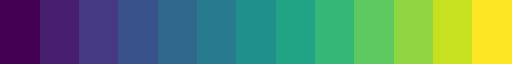

In [11]:
metadata["color_info"] = 0

for i, month in enumerate(sorted(metadata["time_cat"].unique())):
    print(i, month)
    metadata["color_info"][metadata["time_cat"] == month] = i
    
from matplotlib import cm
from matplotlib.colors import ListedColormap

viridis = cm.get_cmap('viridis', 13)
viridis

No antibiotics orange
GBS antibiotics fuchsia


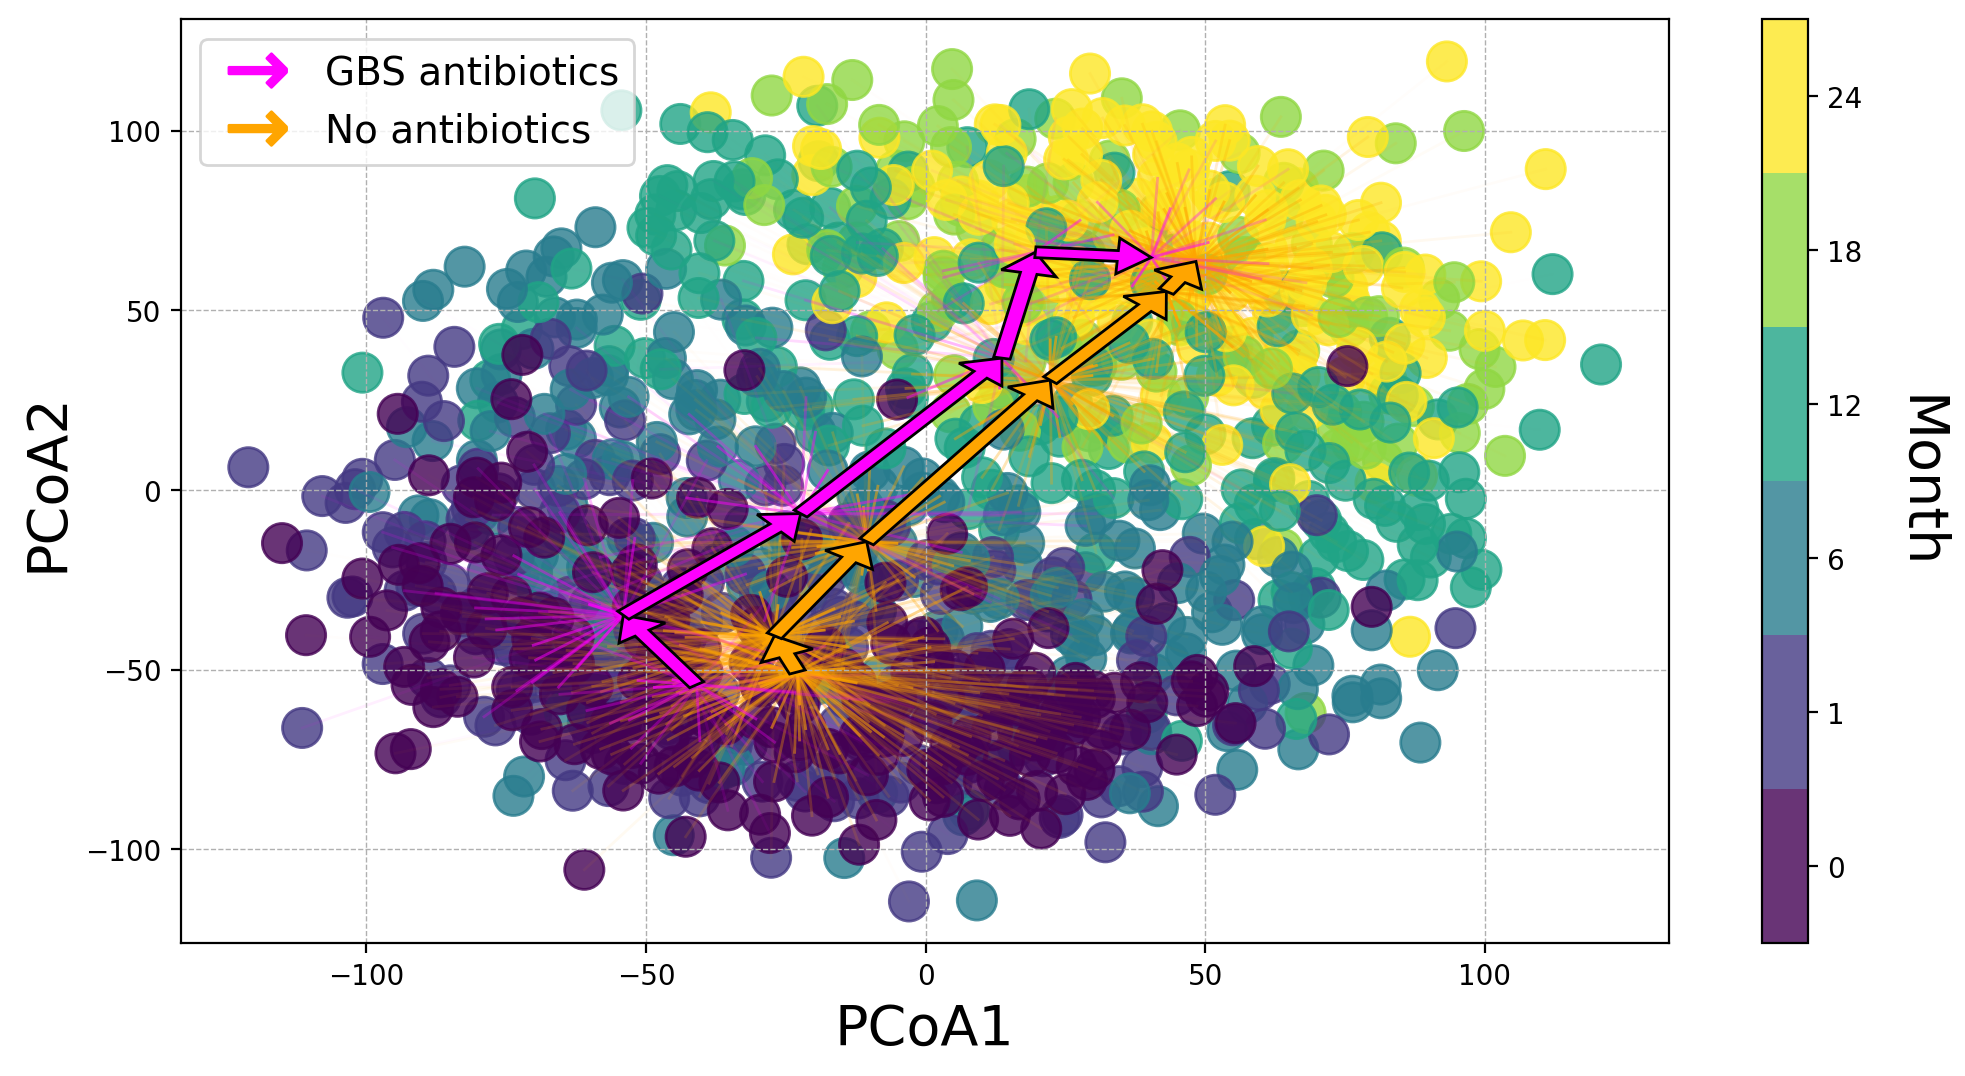

In [12]:
plt.figure(figsize=(12, 6), dpi=200)

arrow_colors = ["orange", "fuchsia"]

ax = plt.gca()
# edgecolors = metadata["expo_cat1"].apply(lambda x : arrow_colors[0] if x == "No antibiotics" else arrow_colors[1])
# alphas = metadata["expo_cat1"].apply(lambda x : 0.8 if x == "No antibiotics" else 0)
sc = ax.scatter(metadata["dim1"], metadata["dim2"], c=metadata["color_info"], alpha=0.8, s=200, cmap=viridis)

tick_labels = sorted(metadata["time_cat"].unique())
cbar = plt.colorbar(sc, orientation="vertical", ticks=np.arange(-1, len(tick_labels)),
                    boundaries=np.arange(-1, len(tick_labels)) + 0.5)
tick_labels = [0] + list(tick_labels)
cbar.ax.set_yticklabels(tick_labels)
cbar.set_label('Month', rotation=270, fontsize=20, labelpad=30)

ax.grid(linestyle = '--', linewidth = 0.5)

ax.set_xlabel("PCoA1", fontsize=20)
ax.set_ylabel("PCoA2", fontsize=20)

for i, abx in enumerate(["No antibiotics", "GBS antibiotics"]):
    print(abx, arrow_colors[i])

    data = metadata[metadata["matabx_expo_cat"] == abx]

    last = None
    for info in sorted(metadata["color_info"].unique()):
        curr_data = data[data["color_info"] == info]
        x = curr_data["dim1"].mean()
        y = curr_data["dim2"].mean()
        
        
        # ---------------- centroid dists -------------------------
        alpha = 1
        
#         compute max_dist
        max_dist = -1
        for row in range(curr_data.shape[0]):
            start_x = x
            end_x = curr_data["dim1"][row]
            start_y = y
            end_y = curr_data["dim2"][row]
            dist = np.sqrt((start_x - end_x) ** 2 + (start_y - end_y) ** 2)
            max_dist = max(max_dist, dist)
        
        for row in range(curr_data.shape[0]):
            start_x = x
            end_x = curr_data["dim1"][row]
            
            start_y = y
            end_y = curr_data["dim2"][row]

            dist = np.sqrt((start_x - end_x) ** 2 + (start_y - end_y) ** 2)
            alpha = np.power((max_dist - dist) / max_dist, 4)
            alpha = 1 if np.isnan(alpha) else alpha
            
            plt.plot((start_x, end_x), (start_y, end_y), c=arrow_colors[i], linewidth=1, zorder=1, 
                     alpha=alpha)
            
        # ---------------- centroid dists -------------------------
        
        if last is not None:
            head_width = 10
            head_length = 6
            width = 3
            plt.arrow(last[0], last[1], x - last[0], y - last[1], width=width, head_width=head_width, head_length=head_length, 
                       length_includes_head=True, facecolor=arrow_colors[i], alpha=1, edgecolor="black", zorder=2)
        last = (x, y)
        
        
plt.scatter([], [], c=arrow_colors[1], marker=r'$\rightarrow$',s=20, label='GBS antibiotics')
plt.scatter([], [], c=arrow_colors[0], marker=r'$\rightarrow$',s=20, label='No antibiotics')

plt.legend(fontsize=14, markerscale=5, loc=2)

plt.show()

In [13]:
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix

info = []

for month in sorted(metadata["time_cat"].unique()):
    print(month)
    data = metadata[(metadata["time_cat"] == month) & (metadata["matabx_expo_cat"] != "Other antibiotics")]
    
    samples = transformed.loc[data.index]
    
    dist = DistanceMetric.get_metric('euclidean')
    dissim = dist.pairwise(samples)
    distance = DistanceMatrix(dissim, tuple(samples.index))
    
#     groups = data["matabx_expo_cat"].apply(lambda x : "No antibiotics" if x == "No antibiotics" else "Abx")
    groups = data["matabx_expo_cat"]
    
    res = permanova(distance, groups)
    print(res)
    p = res.values[-2]
    info.append({"p" : p, "month" : month})

0
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     221
number of groups                  2
test statistic             3.162831
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object
1
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     233
number of groups                  2
test statistic             3.977581
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object
6
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     214
number of groups                  2
test statistic             1.797274
p-value                       0.013
number of permutations          999
Name: PERMANOVA results, dtype: object
12
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     188
number of 

In [14]:
permanova_results = pd.DataFrame(info).set_index("month")
permanova_results

,p
month,
0,0.001
1,0.001
6,0.013
12,0.010
18,0.382
24,0.182


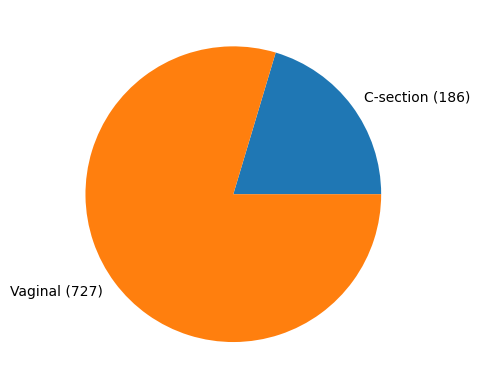

In [15]:
modes, counts = np.unique(metadata[metadata["matabx_expo_cat"] == "No antibiotics"]["del_method"], return_counts=True)
plt.pie(counts, labels=[f"{m} ({c})" for m, c in zip(modes, counts)])
plt.show()

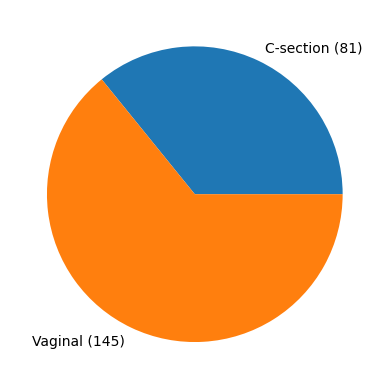

In [16]:
modes, counts = np.unique(metadata[metadata["matabx_expo_cat"] == "GBS antibiotics"]["del_method"], return_counts=True)
plt.pie(counts, labels=[f"{m} ({c})" for m, c in zip(modes, counts)])
plt.show()

In [17]:
from scipy.stats import fisher_exact

gbs = metadata[metadata["matabx_expo_cat"] == "GBS antibiotics"]
no_abx = metadata[metadata["matabx_expo_cat"] == "No antibiotics"]

contingency_table = pd.DataFrame(
    [
        [(gbs["del_method"] == "C-section").sum(), (gbs["del_method"] != "C-section").sum()],
        [(no_abx["del_method"] == "C-section").sum(), (no_abx["del_method"] != "C-section").sum()],
    ],
    index=["GBS", "No abx"],
    columns=["C-section", "Vaginal"]
)
contingency_table

,C-section,Vaginal
GBS,81,145
No abx,186,727


In [18]:
fisher_exact(contingency_table)

SignificanceResult(statistic=2.183426028921023, pvalue=2.7388389911620463e-06)

In [46]:
all(transformed.index == metadata.index)

True

In [47]:
transformed.to_csv("permanova_clr_transformed.csv")
metadata.to_csv("permanova_metadata.csv")